# Steps to do:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [6]:

# Importing Libraries

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

plt.rcParams['figure.figsize'] = [20, 15]



## Camera Calibration & Undistortion
We compute the camera calibration matrix and distortion coefficients using the chess-board images provided for this purpose in the repo. For this we use fucntion calibrateCamera provided in OpenCV lib.

In [2]:
def camera_cal(debug=False):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            if (debug==True):
            # Drawing detected corners on an image
                img = cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        
                plt.figure(figsize=(10,10))
                plt.imshow(img)

    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    #img1 = cv2.imread('./camera_cal/calibration1.jpg')
    #gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
    
    #ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    #gray = cv2.drawChessboardCorners(gray, (9,6), corners, ret)
    #plt.imshow(gray)
    #dst = cv2.undistort(img1, mtx, dist, None, mtx)
    
    #fig, axs = plt.subplots(3)
    #fig.suptitle('Undistorting an image')
    #axs[0].imshow(img1)
    #axs[1].imshow(gray)
    #axs[2].imshow(dst)
    
    
    return mtx, dist



### Test Rig for testing camera calibration function

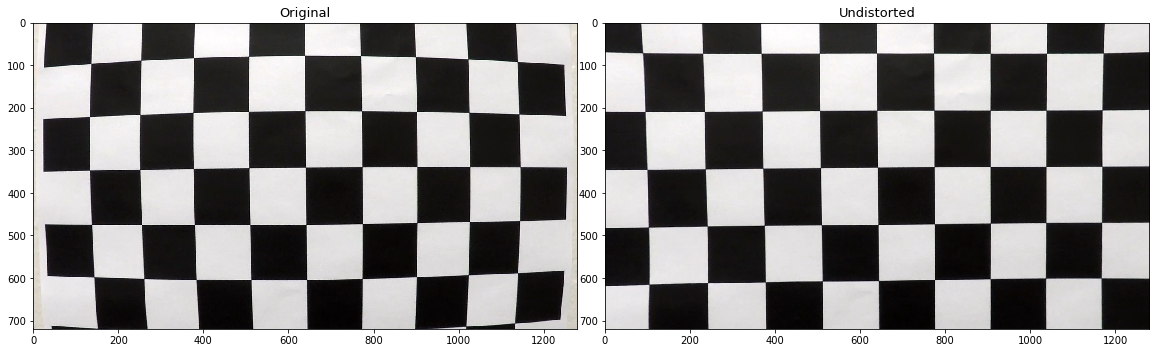

In [11]:
##Checking camera calibration
mtx, dist = camera_cal(debug=False)

# Read a test image
img = mpimg.imread("camera_cal/calibration1.jpg")
# Plot Original and Undistorted Test Image
plt.figure(figsize=(20,50))
plt.subplots_adjust(hspace = .2, wspace=.05)

# Plotting the original image
plt.subplot(1,2,1)
plt.title('Original', fontsize=13)
fig =plt.imshow(img)

# Undistorting the test image
img = cv2.undistort(img, mtx, dist, None, mtx)

# Plotting undistorted image
plt.subplot(1,2,2)
plt.title('Undistorted', fontsize=13)
fig =plt.imshow(img)

## Perspective Transform


In [3]:
def transform_prespective(img, mtx, dist, debug=False):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    img_size = (img.shape[1], img.shape[0])
    offset = 300

    # Source points taken from images with straight lane lines, these are to become parallel after the warp transform
    src = np.float32([
        (190, 720), # bottom-left corner
        (596, 447), # top-left corner
        (685, 447), # top-right corner
        (1125, 720) # bottom-right corner
    ])
    # Destination points are to be parallel, taken into account the image size
    dst = np.float32([
        [offset, img_size[1]],             # bottom-left corner
        [offset, 0],                       # top-left corner
        [img_size[0]-offset, 0],           # top-right corner
        [img_size[0]-offset, img_size[1]]  # bottom-right corner
    ])
    # Calculate the transformation matrix and it's inverse transformation
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undist, M, img_size)
   
    return warped, M_inv



### Test rig for testing perspective transform function

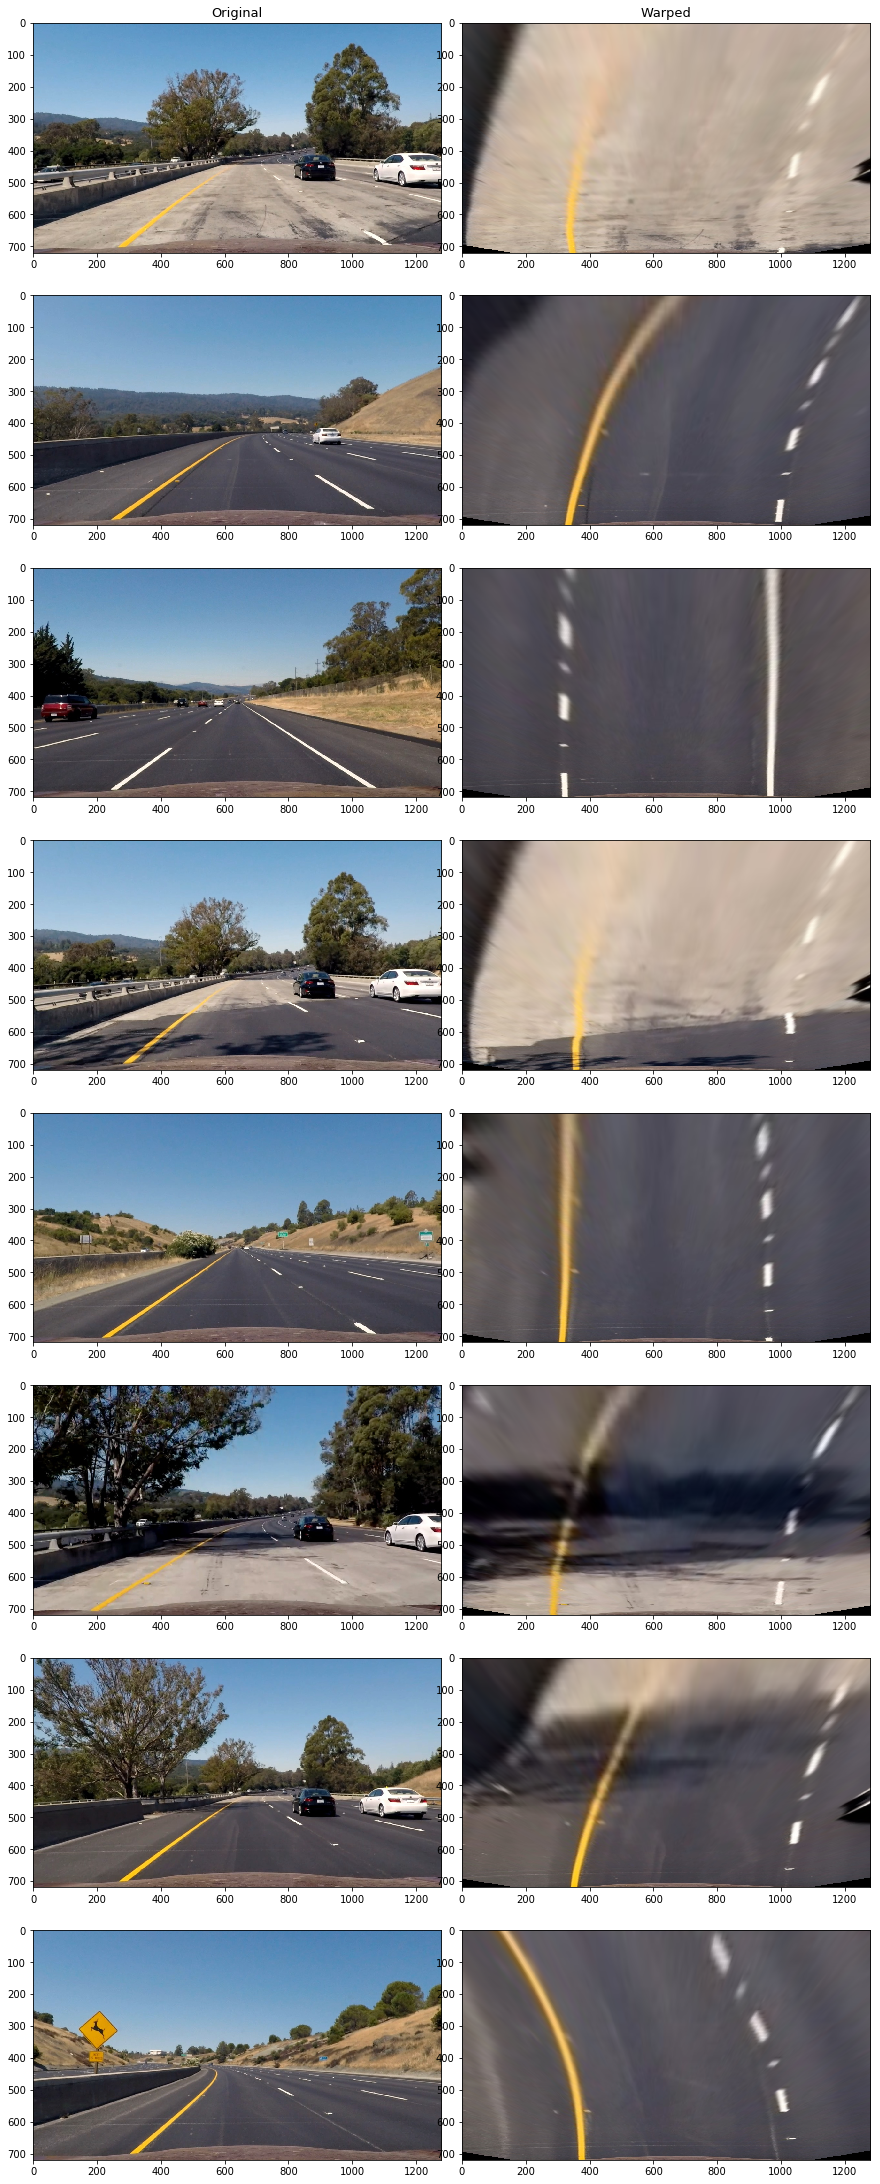

In [38]:
##Checking perspective transformation
mtx, dist = camera_cal(debug=False)

# Read a test images
images = glob.glob('./test_images/*.jpg')

# setting up plot
plt.figure(figsize=(15,5*len(images)))
plt.subplots_adjust(hspace = .02, wspace=.05)

for i in range(len(images)):
    img = mpimg.imread(images[i])
    img = cv2.undistort(img, mtx, dist, None, mtx)

    # Transforming the perspective
    warped, M_inv = transform_prespective(img, mtx, dist, debug=False)

    # Plotting the original image
    plt.subplot(len(images),2,(i*2)+1)
    if (i==0): plt.title('Original', fontsize=13)
    fig =plt.imshow(img)

    # Plotting undistorted & wraped image
    plt.subplot(len(images),2,(i*2)+2)
    if (i==0): plt.title('Warped', fontsize=13)
    fig =plt.imshow(warped)




## Region of interest selector

In [4]:
def ROI_selector(img, debug=False):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #vertices for ROI
    left_top = [int(img.shape[1]/2-50),int(img.shape[0]/2+60)]
    left_bottom = [0,img.shape[0]+100]
    right_top = [int(img.shape[1]/2+50),int(img.shape[0]/2+60)]
    right_bottom = [img.shape[1],img.shape[0]]
    vertices = np.array([[left_top, left_bottom, right_bottom, right_top]],dtype=np.int32)
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)
    debug_img = np.zeros_like(img)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    # return an image with ROI marked
    if (debug==True): 
        pts = vertices.reshape((-1,1,2))
        debug_img = cv2.polylines(img,[pts],True,(255,0,0),3)
    
    return masked_image, debug_img

### Test Rig for ROI selector

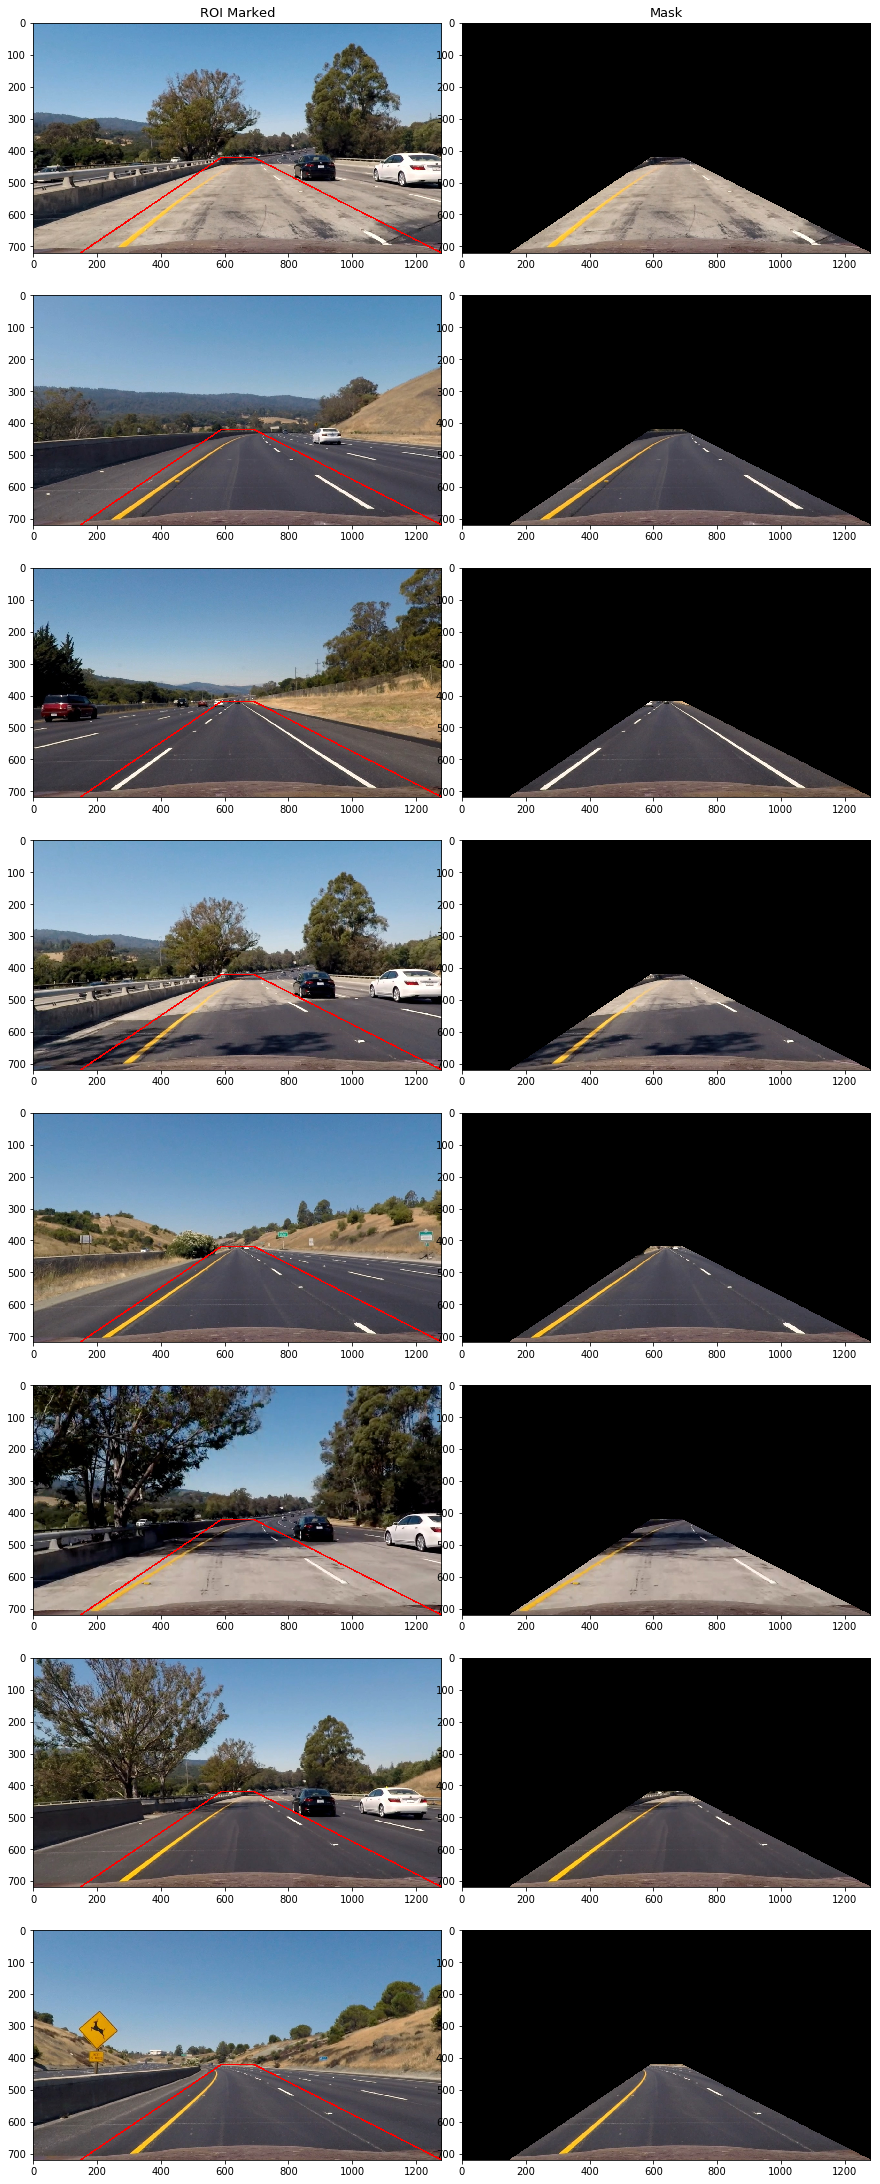

In [7]:
mtx, dist = camera_cal(debug=False)

# Read a test images
images = glob.glob('./test_images/*.jpg')


# setting up plot
plt.figure(figsize=(15,5*len(images)))
plt.subplots_adjust(hspace = .02, wspace=.05)

#Draw region of interest in test images
for i in range(len(images)):
    img = mpimg.imread(images[i])
    img = cv2.undistort(img, mtx, dist, None, mtx)
    mask, debug_img = ROI_selector(img, True)


    # Plotting the original image
    plt.subplot(len(images),2,(i*2)+1)
    if (i==0): plt.title('ROI Marked', fontsize=13)
    fig =plt.imshow(debug_img)

    # Plotting undistorted & wraped image
    plt.subplot(len(images),2,(i*2)+2)
    if (i==0): plt.title('Mask', fontsize=13)
    fig =plt.imshow(mask)


## Thresholded binary 

In [4]:
def binary_thresholded(img):
    # Transform image to gray scale
    gray_img =cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply sobel (derivative) in x direction, this is usefull to detect lines that tend to be vertical
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    # Scale result to 0-255
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sx_binary = np.zeros_like(scaled_sobel)
    # Keep only derivative values that are in the margin of interest
    sx_binary[(scaled_sobel >= 30) & (scaled_sobel <= 255)] = 1

    # Detect pixels that are white in the grayscale image
    white_binary = np.zeros_like(gray_img)
    white_binary[(gray_img > 200) & (gray_img <= 255)] = 1

    # Convert image to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    H = hls[:,:,0]
    S = hls[:,:,2]
    sat_binary = np.zeros_like(S)
    # Detect pixels that have a high saturation value
    sat_binary[(S > 90) & (S <= 255)] = 1

    hue_binary =  np.zeros_like(H)
    # Detect pixels that are yellow using the hue component
    hue_binary[(H > 10) & (H <= 25)] = 1

    # Combine all pixels detected above
    binary_1 = cv2.bitwise_or(sx_binary, white_binary)
    binary_2 = cv2.bitwise_or(hue_binary, sat_binary)
    binary = cv2.bitwise_or(binary_1, binary_2)
    plt.imshow(binary, cmap='gray')

    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Draw figure for binary images
    #f, axarr = plt.subplots(1,6)
    #f.set_size_inches(25, 8)
    #axarr[0].imshow(img)
    #axarr[1].imshow(sx_binary, cmap='gray')
    #axarr[2].imshow(white_binary, cmap='gray')
    #axarr[3].imshow(sat_binary, cmap='gray')
    #axarr[4].imshow(hue_binary, cmap='gray')
    #axarr[5].imshow(binary, cmap='gray')
    #axarr[0].set_title("Undistorted Image")
    #axarr[1].set_title("x Sobel Derivative")
    #axarr[2].set_title("White Threshold")
    #axarr[3].set_title("Saturation Threshold")
    #axarr[4].set_title("Hue Threshold")
    #axarr[5].set_title("Combined")
    #axarr[0].axis('off')
    #axarr[1].axis('off')
    #axarr[2].axis('off')
    #axarr[3].axis('off')
    #axarr[4].axis('off')
    #axarr[5].axis('off')
    
    return binary

In [36]:
def threshold_binary(img):

    # Preliminaries
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel_size = 3
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, kernel_size) # Take the derivative in x
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, kernel_size) # Take the derivative in y
    
    # Directional Gradient both in x & y and then combined
    thresh_min = 30
    thresh_max = 100
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative 
    abs_sobely = np.absolute(sobely) # Absolute y derivative 
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    sobel_bin = np.zeros_like(s_channel)
    sobel_bin[((scaled_sobelx >= thresh_min) & (scaled_sobelx <= thresh_max)) & ((scaled_sobely >= thresh_min) & (scaled_sobely <= thresh_max))] = 1
    
    
    # Gradient magnitude threshold
    thresh_min = 70
    thresh_max = 100
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2) # Calculating the magnitude
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy)) #scaling
    mag_bin = np.zeros_like(s_channel)
    mag_bin[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Gradient direction Threshold
    thresh_min_th = 0.7
    thresh_max_th = 1.3
    theta = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_bin = np.zeros_like(s_channel)
    dir_bin[(theta >= thresh_min_th) & (theta <= thresh_max_th)] = 1
    
    # Combining above two
    mag_dir_binary = np.zeros_like(s_channel)
    mag_dir_binary[((mag_bin == 1) & (dir_bin == 1))] = 1
    
    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in RGB respectively
    color_binary = np.dstack((sobel_bin*255, mag_dir_binary*255, s_binary*255))

    # Combine the binary thresholds
    combined_binary = np.zeros_like(scaled_sobel)
    combined_binary[(s_binary == 1) | (mag_dir_binary == 1) | (sobel_bin == 1)] = 1

    return color_binary

### Test rig for thresholded Binary function

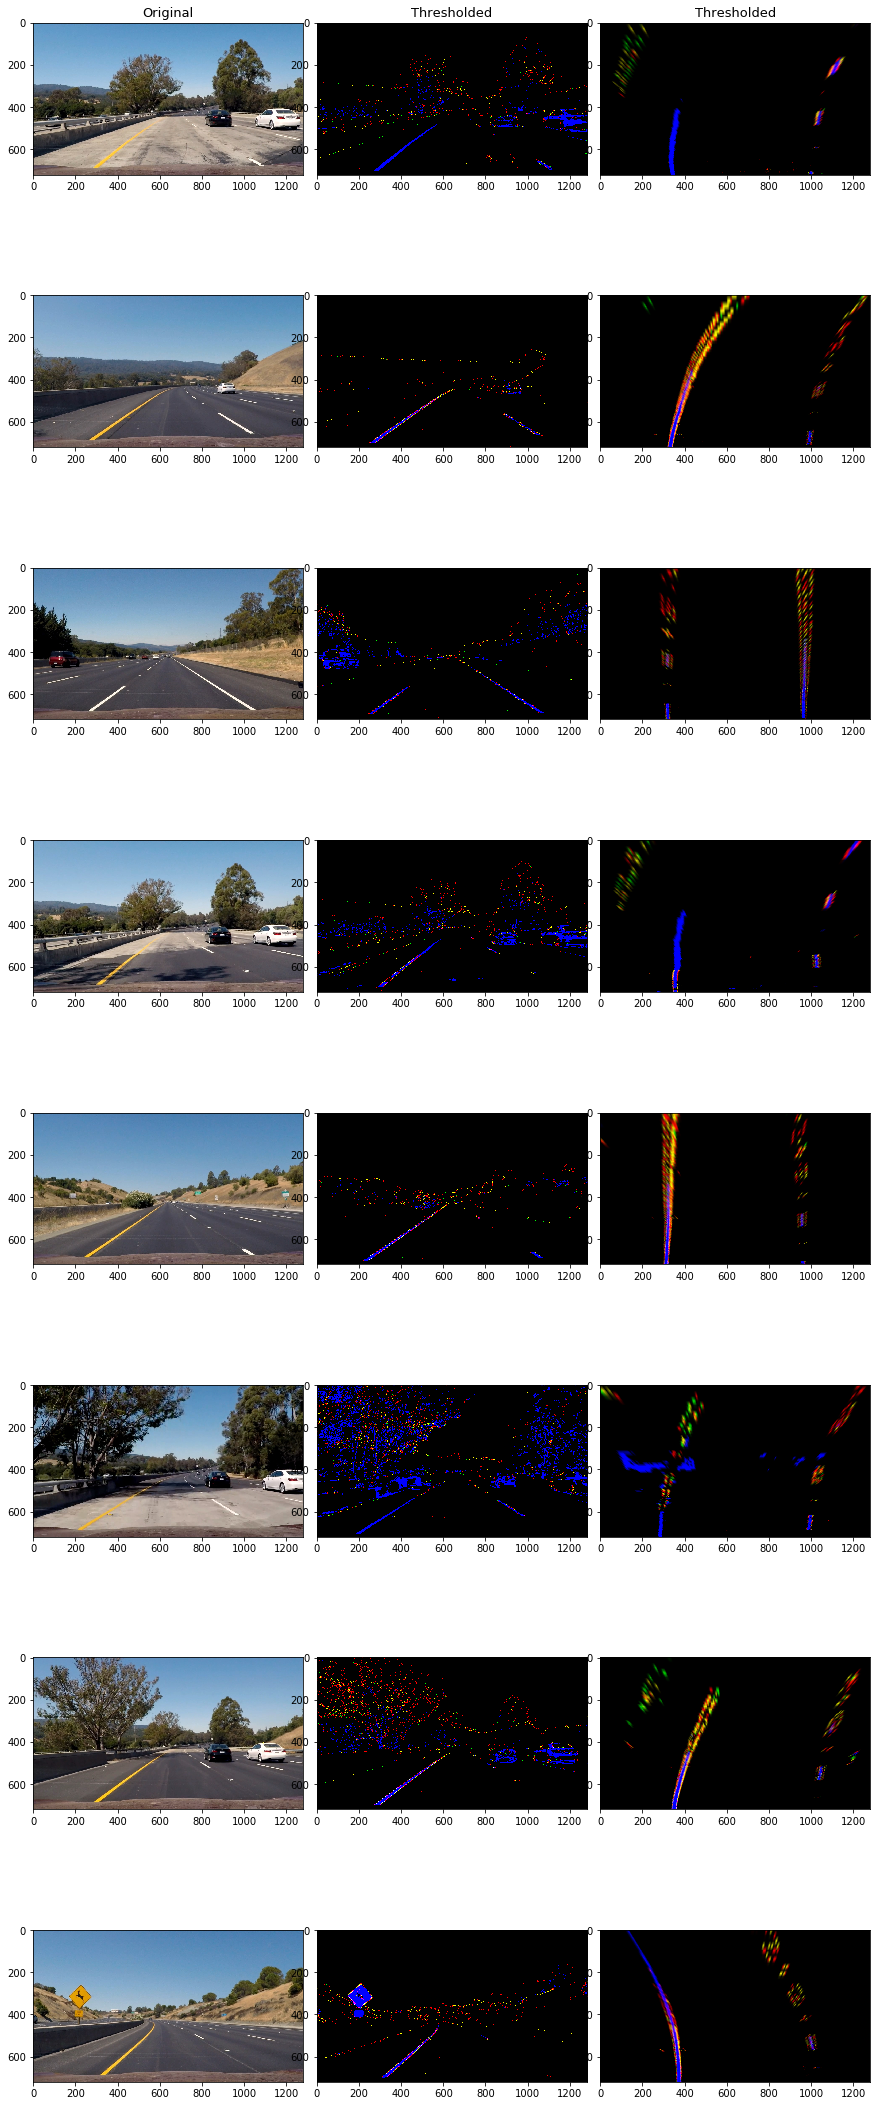

In [37]:
mtx, dist = camera_cal(debug=False)

# Read a test images
images = glob.glob('./test_images/*.jpg')

# setting up plot
plt.figure(figsize=(15,5*len(images)))
plt.subplots_adjust(hspace = .02, wspace=.05)

for i in range(len(images)):
    img = mpimg.imread(images[i])
    img_orig = img.copy()
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    img=threshold_binary(img)
    img_thresh = img.copy()
    
    img, debug_img = ROI_selector(img)

    # Transforming the perspective
    warped, M_inv = transform_prespective(img, mtx, dist, debug=False)
    
    

    # Plotting the original image
    plt.subplot(len(images),3,(i*3)+1)
    if (i==0): plt.title('Original', fontsize=13)
    fig =plt.imshow(img_orig)
    
    # Plotting the thresholded image
    plt.subplot(len(images),3,(i*3)+2)
    if (i==0): plt.title('Thresholded', fontsize=13)
    fig =plt.imshow(img_thresh)

    # Plotting undistorted & wraped image
    plt.subplot(len(images),3,(i*3)+3)
    if (i==0): plt.title('Thresholded', fontsize=13)
    fig =plt.imshow(warped, cmap='gray')
